## Linear Interpolation Example Notebook

by Sheetal Panday  
May 24, 2022   
Reviewed and accepted July 18, 2022

Interpolation is the process of estimating unknown values that fall between known values.

Linear interpolation formula can be written as
`y = y1+((y2-y1)/(x2-x1))*(x-x1)`

In the following example the input file contains a dataset with different target values in pg/ml, which are pre-determined by simulating with different doses, routes and schedules. We want to project a dose using linear interpolation method for a given baseline target level for simulated doses, routes and schedules, where the free target levels remain at or below a certain concentration at trough. A preliminary plot is shown in figure 1 where different target levels are plotted against the total dose and the profiles for various simulated baseline target levels are shown. **A dashed line is plotted that represent a free target level at which we wish to interpolate the total dose.**  

In [1]:
# Import packages 
import pandas as pd
import numpy as np
from scipy import interpolate
from plotnine import *
import collections

In [2]:
# Read and display input file
# Input file has value for target (values in pg/ml) at different dose and schedule at a particular day.

sim_file = "../data/Interpolate_ex_sim.csv" # Simulated input file. 
input_file = pd.read_csv(sim_file)#.astype({'Baseline_target': 'str'})
display(input_file)

,Dose_mg,Dose_route,Schedule,Baseline_target,t_days,measurement
0,0.010000,IV,Q3W,500.0,168.0,499.902839
1,0.012949,IV,Q3W,500.0,168.0,499.874152
2,0.016768,IV,Q3W,500.0,168.0,499.836995
3,0.021714,IV,Q3W,500.0,168.0,499.788822
4,0.028118,IV,Q3W,500.0,168.0,499.726401
...,...,...,...,...,...,...
895,1124.657822,SC,Q4W,40000.0,224.0,909.186817
896,1456.348478,SC,Q4W,40000.0,224.0,448.373765
897,1885.863279,SC,Q4W,40000.0,224.0,267.759731
898,2442.053095,SC,Q4W,40000.0,224.0,175.648647


In [3]:
input_file.dtypes

Dose_mg            float64
Dose_route          object
Schedule            object
Baseline_target    float64
t_days             float64
measurement        float64
dtype: object

In [4]:
# Apply ABM color palette
abm_colors = {
    'green': '#00843D',
    'purple': '#500778',
    'gold': '#D5AF34',
    'gray': '#707372',
    'teal': '#0F758C',
    'burnt orange': '#A65725',
    'black': '#000000',
    'vermillion' : '#E69F00',
    'yellow' : '#F0E442',
    'gray' : '#BBBBBB',
}

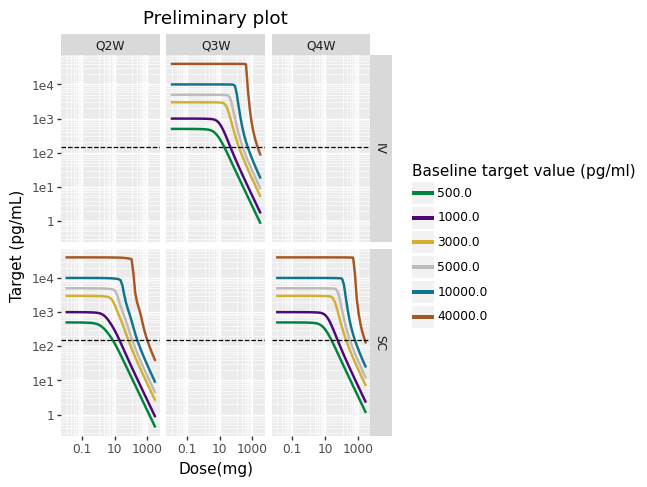

In [5]:
# Preliminary plot - plots total dose (mg) on X-axis and value of the free target (in pg/ml) on the y-axis.  
# Facet wrapping is done according to the schedule and dose route.

# Point at which we perform interpolation
value_interpolate = 150 

Figure_1 = (ggplot(input_file, aes('Dose_mg', 'measurement', color='factor(Baseline_target)')) #
    + geom_line(size=1)
    + facet_grid('Dose_route~Schedule')
    + scale_x_log10()
    + scale_y_log10()
    + geom_hline(yintercept = value_interpolate, linetype = '--', color = 'black') # We want to interpolate the dose at the value_interpolate value
    + labs(title='Preliminary plot',
           x='Dose(mg)',
           y='Target (pg/mL)',
           color = 'Baseline target value (pg/ml)')
    + scale_color_manual(values=list(abm_colors.values()))) 
Figure_1.draw()
# Figure_1.save('results/Prelimnary_plot.png', width=12, height=10) # saving plot in results folder

Essentially we want to determine points (which represent total dose) where the black dashed line cuts each of the different baseline target profiles for the simulated dosing regimens by using linear interpolation method. This is shown in figure 2.

In [6]:
# For loop is used to determine the dose for different baseline levels to keep free
# target levels at trough at value_interpolate pg/ml 

# Labels to use in groupby to group columns in dataframe
group_cols = ['Dose_route','Schedule','Baseline_target']

# List of dictionaries where the interpolated values with their labels information are stored
results_list = []
for group_vals, results_sub in input_file.groupby(group_cols):
    
    results_sub = results_sub.sort_values('measurement')
    
    # xp corresponds to the values in the independent axis (x-axis)
    xp = results_sub.measurement
    # fp corresponds to the values in the dependent axis (y-axis)
    fp = results_sub.Dose_mg
    
    # Check for duplicate xps
    xp_dup = [f"{item:.6g}" for item, count in collections.Counter(xp).items() if count > 1]
    if len(xp_dup) > 0:
        raise ValueError(f"Duplicate xp values were found: {', '.join(xp_dup)}")
        
    # Check for NaNs in xp or fp
    if any(np.isnan(xpi) for xpi in xp):
        raise ValueError("NaNs were found in xp.")
    if any(np.isnan(fpi) for fpi in fp):
        raise ValueError("NaNs were found in fp.")
    
    # Point in the x-axis at which we perform interpolation to
    # obtain the y-axis value
    x = value_interpolate
    
    # Creates function that interpolates between the xp and fp values.
    # We set bounds_error to True so that a ValueError is raised any time
    # interpolation is attempted on a value outside of the range of x
    f_interp = interpolate.interp1d(xp, fp, bounds_error=True)
    
    # Value in the y-axis that we get from the interpolation
    interp_value = float(f_interp(x))
        
    results_list.append({col:val for col,val in zip(group_cols,group_vals)} | {'dose_interp_pgml':interp_value})

Tinterp = pd.DataFrame(results_list)

# Below command is created to get color sorting according to dose route and schedule 

Tinterp['schedule_and_route'] = Tinterp.Schedule + " " + Tinterp.Dose_route
display(Tinterp)

,Dose_route,Schedule,Baseline_target,dose_interp_pgml,schedule_and_route
0,IV,Q3W,500.0,18.404572,Q3W IV
1,IV,Q3W,1000.0,44.445509,Q3W IV
2,IV,Q3W,3000.0,146.321699,Q3W IV
3,IV,Q3W,5000.0,249.829983,Q3W IV
4,IV,Q3W,10000.0,505.925355,Q3W IV
5,IV,Q3W,40000.0,2068.070518,Q3W IV
6,SC,Q2W,500.0,7.922823,Q2W SC
7,SC,Q2W,1000.0,20.610010,Q2W SC
8,SC,Q2W,3000.0,72.352861,Q2W SC
9,SC,Q2W,5000.0,124.582596,Q2W SC


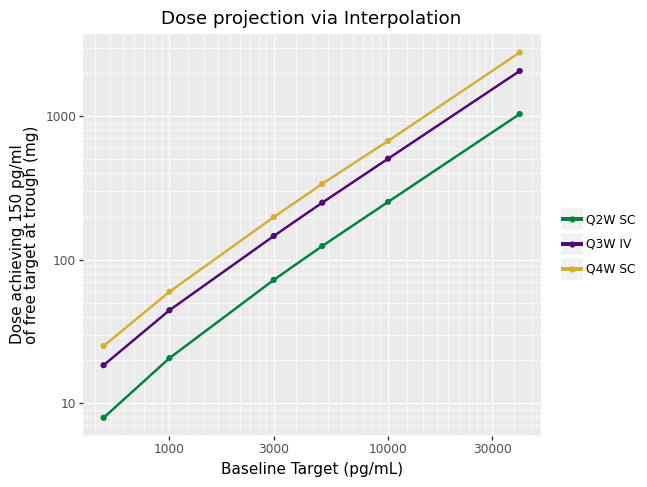

In [7]:
Figure_2 = (ggplot(Tinterp, aes('Baseline_target', 'dose_interp_pgml', color='schedule_and_route'))
    + geom_line(size = 1)
    + geom_point()
    + scale_x_log10()
    + scale_y_log10()
    # + coord_cartesian(xlim=[2.5,4.7],ylim = [-0.7,3.7])
    + labs(title='Dose projection via Interpolation', x = 'Baseline Target (pg/mL)',
           y = f'Dose achieving {value_interpolate} pg/ml\nof free target at trough (mg)', color = '')
    + scale_color_manual(values=list(abm_colors.values()))
           )
Figure_2.draw()
# Figure_2.save('results/Dose_projection.png', width=4, height=4)